In [25]:
%matplotlib inline

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import glob
import h5py

In [28]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [29]:
torch.__version__

'1.0.0'

In [30]:
gpu = 4
multi_gpus = None #[0, 1, 2]
b = 4
zero_one_normalize = False
zoom = 0.525

dtype = np.float64

In [31]:
# load mask
mask = None

In [32]:
train_h5 = h5py.File('/ritter/share/data/MS/CIS/train_dataset.h5', 'r')
holdout_h5 = h5py.File('/ritter/share/data/MS/CIS/holdout_dataset.h5', 'r')

In [33]:
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']
X_train, y_train = train_h5['X'], train_h5['y']

In [34]:
# define dataset

In [35]:
class MSDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=zoom, dtype=np.float32):
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = zoom
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
            
        sample = {"image" : image,
                 "label" : label}
        return sample

In [36]:
if zero_one_normalize:
    intensity = IntensityRescale()
    ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
    ms_data_test = MSDataset(X_holdout, y_holdout, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
else:
    ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
    ms_data_test = MSDataset(X_holdout, y_holdout, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)

In [37]:
sample = ms_data_train[29]
img = sample["image"]

In [38]:
img.shape

torch.Size([1, 96, 114, 96])

Text(0.5, 1.0, '1.0')

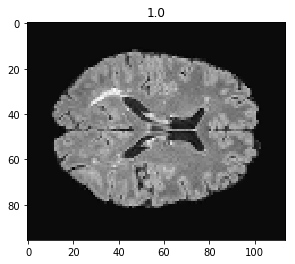

In [39]:
plt.imshow(img[0][:,:,46], cmap='gray')
plt.title(sample["label"].item())

# Define the classifier

In [40]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.dropout = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)

        self.classifier_scratch = nn.Sequential(
            nn.Linear(128, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.dropout(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_4(x))
        if print_size:
            print(h.shape)    
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [41]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [42]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 333889


# Training

In [19]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      

    all_indices = list(range(len(data)))
    train_idx, val_idx = train_test_split(all_indices, test_size=0.1, random_state=12)
    fold_metric = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        print("Shuffled the data..")

        if zero_one_normalize:
            intensity = IntensityRescale()
            ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
        else:
            ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
        
        train_loader = DataLoader(
            ms_data_train, batch_size=b, num_workers=4, sampler=train_sampler
        )
        val_loader = DataLoader(
            ms_data_train, batch_size=1, num_workers=1, sampler=val_sampler
        )

        sample = next(iter(train_loader))
        img = sample["image"][0]
        lbl = sample["label"][0]
        print(img.shape)
        print(len(train_loader))
        plt.imshow(img.squeeze()[:,:,48], cmap='gray')
        plt.title(lbl.item())
        plt.show()
        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=20,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric]))
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric.__name__]))

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    return fold_metric, models

In [43]:
num_epochs = 200
min_iters = 3
ignore_epochs = 5
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [44]:
r = 4

In [45]:
augmentations = [] # augmentations seem to decrease validation accuracy

output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/MS/full_set/baseline/"
callbacks = [EarlyStopping(patience=16, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
             ModelCheckpoint(path=output_dir,
                             prepend="repeat_{}".format(r),
                             store_best=True,
                             ignore_before=ignore_epochs,
                             retain_metric=retain_metric)]

Starting trial 0
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


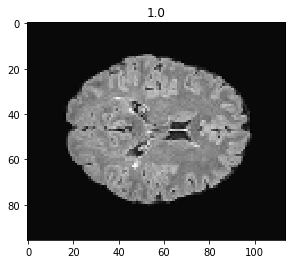

[0,    20] loss: 0.70282
Time elapsed: 0h:0m:4s
train accuracy_score: 45.95 %
train balanced_accuracy: 46.64 %
val accuracy_score: 38.46 %
val balanced_accuracy: 55.56 %
Val loss: 0.711392
[1,    20] loss: 0.69085
Time elapsed: 0h:0m:8s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.731304
[2,    20] loss: 0.68980
Time elapsed: 0h:0m:12s
train accuracy_score: 52.25 %
train balanced_accuracy: 49.15 %
val accuracy_score: 30.77 %
val balanced_accuracy: 36.11 %
Val loss: 0.708582
[3,    20] loss: 0.69498
Time elapsed: 0h:0m:17s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.703867
[4,    20] loss: 0.69715
Time elapsed: 0h:0m:21s
train accuracy_score: 52.25 %
train balanced_accuracy: 52.80 %
val accuracy_score: 38.46 %
val balanced_accuracy: 55.56 %
Val loss: 0.718212
[5,    20] loss: 0.69376
Time elapsed: 0h:0m:26s
tra

[43,    20] loss: 0.40583
Time elapsed: 0h:3m:19s
train accuracy_score: 77.48 %
train balanced_accuracy: 76.99 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.39 %
Val loss: 0.446562
[44,    20] loss: 0.47158
Time elapsed: 0h:3m:24s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.67 %
val accuracy_score: 84.62 %
val balanced_accuracy: 81.94 %
Val loss: 0.351731
[45,    20] loss: 0.41669
Time elapsed: 0h:3m:28s
train accuracy_score: 86.49 %
train balanced_accuracy: 86.49 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.391457
[46,    20] loss: 0.45904
Time elapsed: 0h:3m:33s
train accuracy_score: 81.98 %
train balanced_accuracy: 82.14 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.374736
[47,    20] loss: 0.41794
Time elapsed: 0h:3m:38s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.44 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.39 %
Val loss: 0.383170
[48,    20] loss: 0.44720
Time elapsed: 0h:3m

[86,    20] loss: 0.07070
Time elapsed: 0h:6m:36s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.04 %
val accuracy_score: 84.62 %
val balanced_accuracy: 81.94 %
Val loss: 0.237984
[87,    20] loss: 0.08044
Time elapsed: 0h:6m:41s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.04 %
val accuracy_score: 92.31 %
val balanced_accuracy: 87.50 %
Val loss: 0.185921
[88,    20] loss: 0.04708
Time elapsed: 0h:6m:45s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.202833
[89,    20] loss: 0.06310
Time elapsed: 0h:6m:50s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.318926
[90,    20] loss: 0.04256
Time elapsed: 0h:6m:54s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.187548
[91,    20] loss: 0.04967
Time elapsed: 0h:

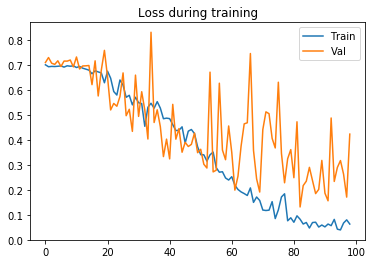

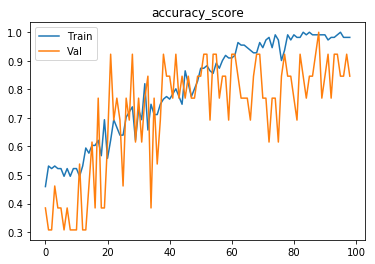

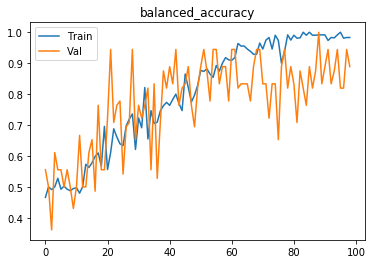

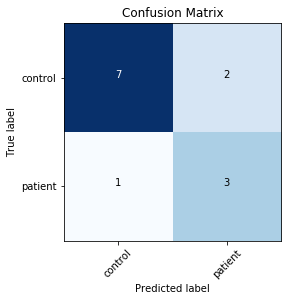

Starting trial 1
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


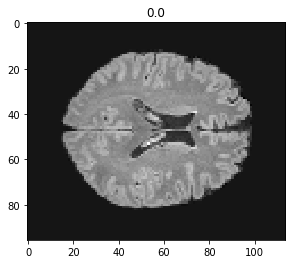

[0,    20] loss: 0.70115
Time elapsed: 0h:0m:3s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.23 %
val accuracy_score: 53.85 %
val balanced_accuracy: 66.67 %
Val loss: 0.695065
[1,    20] loss: 0.70196
Time elapsed: 0h:0m:8s
train accuracy_score: 45.95 %
train balanced_accuracy: 45.84 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.734061
[2,    20] loss: 0.71596
Time elapsed: 0h:0m:13s
train accuracy_score: 41.44 %
train balanced_accuracy: 39.44 %
val accuracy_score: 46.15 %
val balanced_accuracy: 47.22 %
Val loss: 0.693843
[3,    20] loss: 0.69391
Time elapsed: 0h:0m:17s
train accuracy_score: 52.25 %
train balanced_accuracy: 49.27 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.727176
[4,    20] loss: 0.69516
Time elapsed: 0h:0m:22s
train accuracy_score: 52.25 %
train balanced_accuracy: 49.15 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.726985
[5,    20] loss: 0.69994
Time elapsed: 0h:0m:27s
tra

[43,    20] loss: 0.51254
Time elapsed: 0h:3m:21s
train accuracy_score: 80.18 %
train balanced_accuracy: 80.44 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.643612
[44,    20] loss: 0.44574
Time elapsed: 0h:3m:26s
train accuracy_score: 80.18 %
train balanced_accuracy: 79.99 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.656156
[45,    20] loss: 0.41638
Time elapsed: 0h:3m:30s
train accuracy_score: 81.98 %
train balanced_accuracy: 81.68 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.83 %
Val loss: 0.426273
[46,    20] loss: 0.42658
Time elapsed: 0h:3m:35s
train accuracy_score: 81.98 %
train balanced_accuracy: 81.80 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.83 %
Val loss: 0.525775
[47,    20] loss: 0.41982
Time elapsed: 0h:3m:39s
train accuracy_score: 81.98 %
train balanced_accuracy: 81.68 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.450086
[48,    20] loss: 0.37742
Time elapsed: 0h:3m

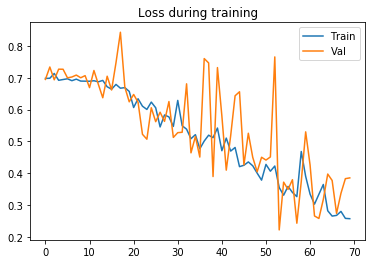

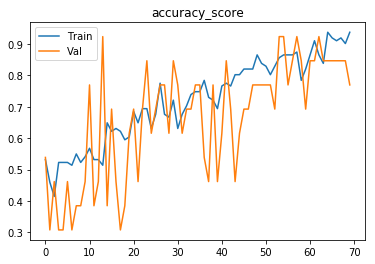

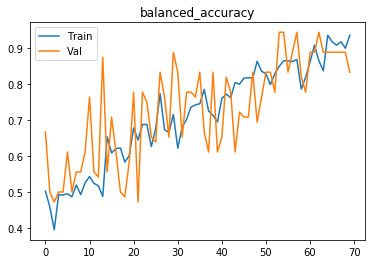

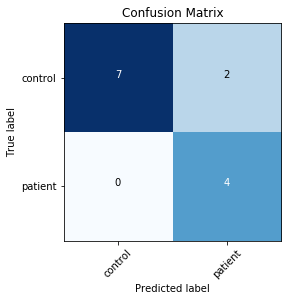

Starting trial 2
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


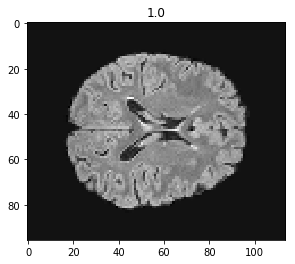

[0,    20] loss: 0.69644
Time elapsed: 0h:0m:4s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.23 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.714947
[1,    20] loss: 0.70077
Time elapsed: 0h:0m:8s
train accuracy_score: 43.24 %
train balanced_accuracy: 41.70 %
val accuracy_score: 23.08 %
val balanced_accuracy: 37.50 %
Val loss: 0.715201
[2,    20] loss: 0.69119
Time elapsed: 0h:0m:13s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 38.46 %
val balanced_accuracy: 41.67 %
Val loss: 0.702041
[3,    20] loss: 0.69924
Time elapsed: 0h:0m:18s
train accuracy_score: 46.85 %
train balanced_accuracy: 47.15 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.719391
[4,    20] loss: 0.69270
Time elapsed: 0h:0m:22s
train accuracy_score: 54.95 %
train balanced_accuracy: 51.92 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.710572
[5,    20] loss: 0.70361
Time elapsed: 0h:0m:27s
tra

[43,    20] loss: 0.43201
Time elapsed: 0h:3m:21s
train accuracy_score: 84.68 %
train balanced_accuracy: 84.45 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.435431
[44,    20] loss: 0.33960
Time elapsed: 0h:3m:25s
train accuracy_score: 85.59 %
train balanced_accuracy: 85.30 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.442319
[45,    20] loss: 0.33056
Time elapsed: 0h:3m:30s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.22 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.674010
[46,    20] loss: 0.37030
Time elapsed: 0h:3m:34s
train accuracy_score: 81.98 %
train balanced_accuracy: 82.25 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.585379
[47,    20] loss: 0.39977
Time elapsed: 0h:3m:39s
train accuracy_score: 81.98 %
train balanced_accuracy: 81.57 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.502548
[48,    20] loss: 0.33804
Time elapsed: 0h:3m

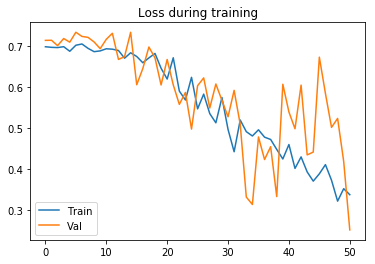

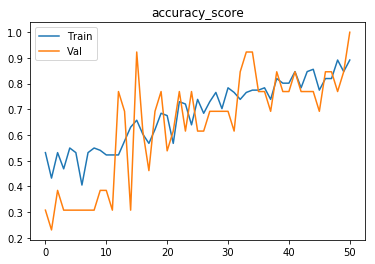

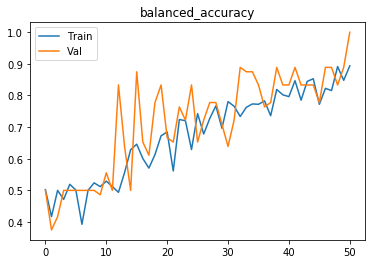

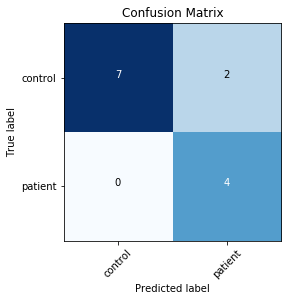

Starting trial 3
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


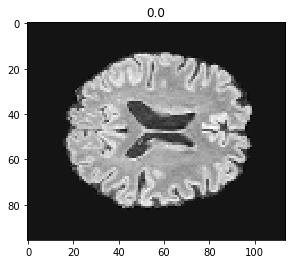

[0,    20] loss: 0.70704
Time elapsed: 0h:0m:4s
train accuracy_score: 54.05 %
train balanced_accuracy: 52.33 %
val accuracy_score: 69.23 %
val balanced_accuracy: 63.89 %
Val loss: 0.693423
[1,    20] loss: 0.70124
Time elapsed: 0h:0m:8s
train accuracy_score: 45.05 %
train balanced_accuracy: 43.63 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.721846
[2,    20] loss: 0.69624
Time elapsed: 0h:0m:13s
train accuracy_score: 54.05 %
train balanced_accuracy: 51.19 %
val accuracy_score: 53.85 %
val balanced_accuracy: 59.72 %
Val loss: 0.694846
[3,    20] loss: 0.68653
Time elapsed: 0h:0m:17s
train accuracy_score: 59.46 %
train balanced_accuracy: 59.47 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.786092
[4,    20] loss: 0.68499
Time elapsed: 0h:0m:22s
train accuracy_score: 57.66 %
train balanced_accuracy: 55.38 %
val accuracy_score: 53.85 %
val balanced_accuracy: 45.83 %
Val loss: 0.658340
[5,    20] loss: 0.69948
Time elapsed: 0h:0m:26s
tra

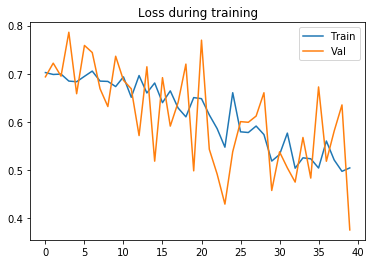

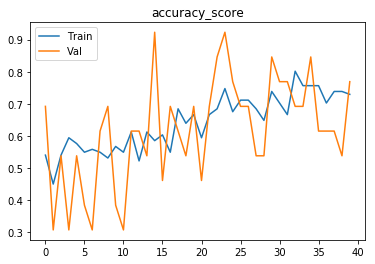

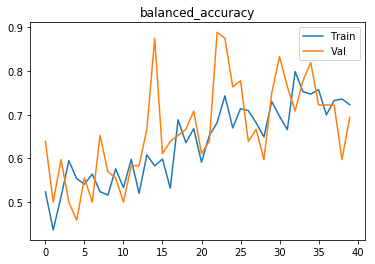

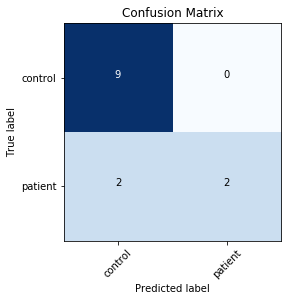

Starting trial 4
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


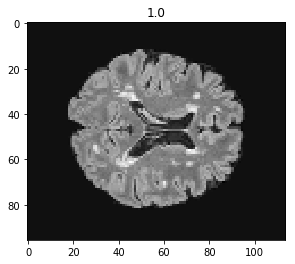

[0,    20] loss: 0.69363
Time elapsed: 0h:0m:4s
train accuracy_score: 48.65 %
train balanced_accuracy: 46.90 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.741224
[1,    20] loss: 0.69840
Time elapsed: 0h:0m:8s
train accuracy_score: 45.05 %
train balanced_accuracy: 43.51 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.702993
[2,    20] loss: 0.67732
Time elapsed: 0h:0m:13s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.57 %
val accuracy_score: 69.23 %
val balanced_accuracy: 63.89 %
Val loss: 0.664056
[3,    20] loss: 0.70222
Time elapsed: 0h:0m:17s
train accuracy_score: 45.95 %
train balanced_accuracy: 48.01 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.722929
[4,    20] loss: 0.69854
Time elapsed: 0h:0m:22s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.07 %
val accuracy_score: 53.85 %
val balanced_accuracy: 66.67 %
Val loss: 0.694454
[5,    20] loss: 0.71000
Time elapsed: 0h:0m:27s
tra

[43,    20] loss: 0.46500
Time elapsed: 0h:3m:21s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.18 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.665859
[44,    20] loss: 0.47082
Time elapsed: 0h:3m:25s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.37 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.83 %
Val loss: 0.430666
[45,    20] loss: 0.41736
Time elapsed: 0h:3m:30s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.18 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.443694
[46,    20] loss: 0.41227
Time elapsed: 0h:3m:35s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.33 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.627572
[47,    20] loss: 0.37907
Time elapsed: 0h:3m:39s
train accuracy_score: 82.88 %
train balanced_accuracy: 82.53 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.433122
[48,    20] loss: 0.37309
Time elapsed: 0h:3m

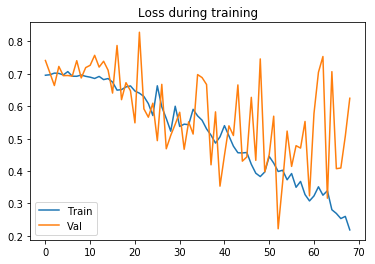

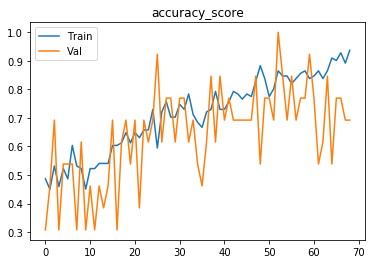

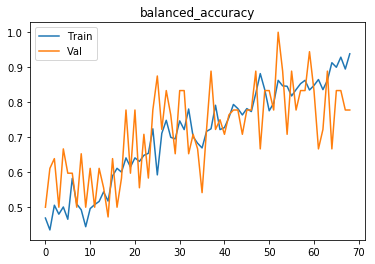

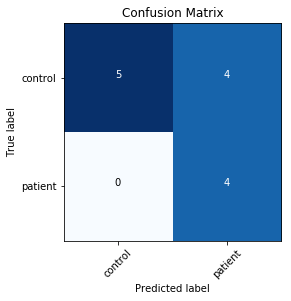

Starting trial 5
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


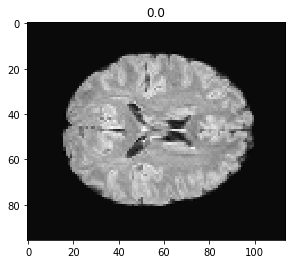

[0,    20] loss: 0.69783
Time elapsed: 0h:0m:4s
train accuracy_score: 51.35 %
train balanced_accuracy: 48.99 %
val accuracy_score: 53.85 %
val balanced_accuracy: 59.72 %
Val loss: 0.694526
[1,    20] loss: 0.68344
Time elapsed: 0h:0m:8s
train accuracy_score: 53.15 %
train balanced_accuracy: 51.71 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.757854
[2,    20] loss: 0.69764
Time elapsed: 0h:0m:13s
train accuracy_score: 50.45 %
train balanced_accuracy: 49.28 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.704495
[3,    20] loss: 0.70235
Time elapsed: 0h:0m:17s
train accuracy_score: 44.14 %
train balanced_accuracy: 43.69 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.701038
[4,    20] loss: 0.69729
Time elapsed: 0h:0m:22s
train accuracy_score: 54.05 %
train balanced_accuracy: 52.56 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.767508
[5,    20] loss: 0.69988
Time elapsed: 0h:0m:27s
tra

[43,    20] loss: 0.40922
Time elapsed: 0h:3m:20s
train accuracy_score: 84.68 %
train balanced_accuracy: 84.79 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.525061
[44,    20] loss: 0.38883
Time elapsed: 0h:3m:25s
train accuracy_score: 84.68 %
train balanced_accuracy: 84.45 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.434266
[45,    20] loss: 0.39645
Time elapsed: 0h:3m:30s
train accuracy_score: 82.88 %
train balanced_accuracy: 82.64 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.360247
[46,    20] loss: 0.46804
Time elapsed: 0h:3m:34s
train accuracy_score: 79.28 %
train balanced_accuracy: 78.91 %
val accuracy_score: 92.31 %
val balanced_accuracy: 87.50 %
Val loss: 0.318293
[47,    20] loss: 0.42082
Time elapsed: 0h:3m:39s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.10 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.433000
[48,    20] loss: 0.36363
Time elapsed: 0h:3m

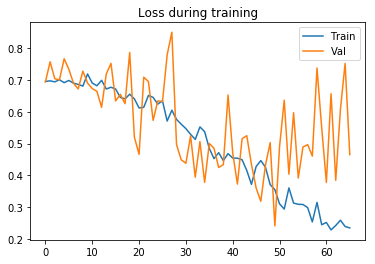

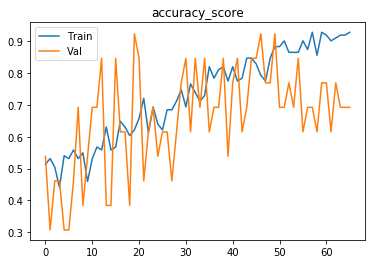

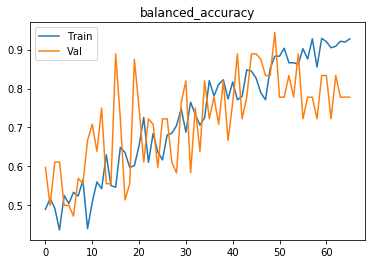

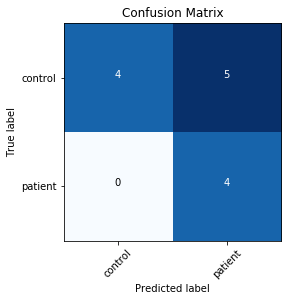

Starting trial 6
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


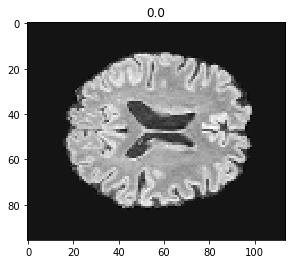

[0,    20] loss: 0.69723
Time elapsed: 0h:0m:4s
train accuracy_score: 45.05 %
train balanced_accuracy: 44.20 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.714408
[1,    20] loss: 0.70496
Time elapsed: 0h:0m:8s
train accuracy_score: 49.55 %
train balanced_accuracy: 49.35 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.733215
[2,    20] loss: 0.70209
Time elapsed: 0h:0m:13s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.704299
[3,    20] loss: 0.69519
Time elapsed: 0h:0m:17s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 23.08 %
val balanced_accuracy: 37.50 %
Val loss: 0.720021
[4,    20] loss: 0.69857
Time elapsed: 0h:0m:22s
train accuracy_score: 50.45 %
train balanced_accuracy: 49.40 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.720585
[5,    20] loss: 0.69230
Time elapsed: 0h:0m:27s
tra

[43,    20] loss: 0.42575
Time elapsed: 0h:3m:21s
train accuracy_score: 81.98 %
train balanced_accuracy: 81.80 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.262668
[44,    20] loss: 0.44591
Time elapsed: 0h:3m:26s
train accuracy_score: 83.78 %
train balanced_accuracy: 83.49 %
val accuracy_score: 76.92 %
val balanced_accuracy: 62.50 %
Val loss: 0.387762
[45,    20] loss: 0.48780
Time elapsed: 0h:3m:30s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.60 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.353638
[46,    20] loss: 0.36644
Time elapsed: 0h:3m:35s
train accuracy_score: 83.78 %
train balanced_accuracy: 83.60 %
val accuracy_score: 92.31 %
val balanced_accuracy: 87.50 %
Val loss: 0.289046
[47,    20] loss: 0.40786
Time elapsed: 0h:3m:39s
train accuracy_score: 84.68 %
train balanced_accuracy: 84.68 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.463470
[48,    20] loss: 0.33367
Time elapsed: 0h:

[86,    20] loss: 0.08233
Time elapsed: 0h:6m:38s
train accuracy_score: 96.40 %
train balanced_accuracy: 96.38 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.265878
[87,    20] loss: 0.05387
Time elapsed: 0h:6m:43s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.229834
[88,    20] loss: 0.03877
Time elapsed: 0h:6m:48s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.311318
[89,    20] loss: 0.06467
Time elapsed: 0h:6m:52s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.383599
[90,    20] loss: 0.06979
Time elapsed: 0h:6m:57s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 1.039851
[91,    20] loss: 0.09808
Time elapsed: 0h:

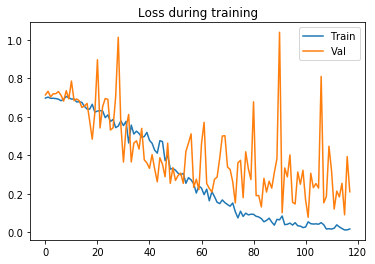

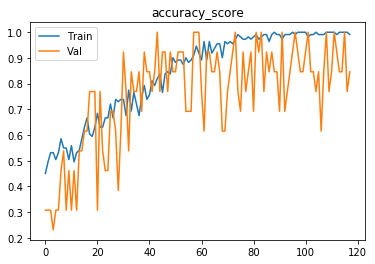

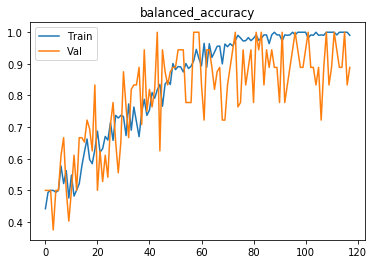

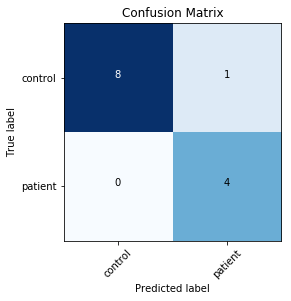

Starting trial 7
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


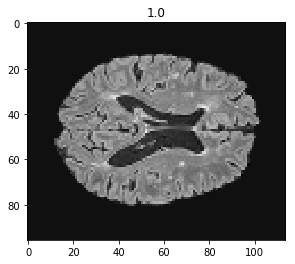

[0,    20] loss: 0.69137
Time elapsed: 0h:0m:3s
train accuracy_score: 49.55 %
train balanced_accuracy: 48.09 %
val accuracy_score: 53.85 %
val balanced_accuracy: 66.67 %
Val loss: 0.707102
[1,    20] loss: 0.69775
Time elapsed: 0h:0m:8s
train accuracy_score: 48.65 %
train balanced_accuracy: 46.79 %
val accuracy_score: 15.38 %
val balanced_accuracy: 18.06 %
Val loss: 0.740744
[2,    20] loss: 0.69614
Time elapsed: 0h:0m:13s
train accuracy_score: 54.95 %
train balanced_accuracy: 52.72 %
val accuracy_score: 46.15 %
val balanced_accuracy: 47.22 %
Val loss: 0.691884
[3,    20] loss: 0.67711
Time elapsed: 0h:0m:17s
train accuracy_score: 58.56 %
train balanced_accuracy: 56.80 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.83 %
Val loss: 0.663315
[4,    20] loss: 0.68694
Time elapsed: 0h:0m:22s
train accuracy_score: 50.45 %
train balanced_accuracy: 49.51 %
val accuracy_score: 53.85 %
val balanced_accuracy: 66.67 %
Val loss: 0.707562
[5,    20] loss: 0.72944
Time elapsed: 0h:0m:26s
tra

[43,    20] loss: 0.42489
Time elapsed: 0h:3m:21s
train accuracy_score: 81.08 %
train balanced_accuracy: 80.72 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.39 %
Val loss: 0.370974
[44,    20] loss: 0.45160
Time elapsed: 0h:3m:26s
train accuracy_score: 81.08 %
train balanced_accuracy: 81.18 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.461203
[45,    20] loss: 0.45177
Time elapsed: 0h:3m:30s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.44 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.455854
[46,    20] loss: 0.33822
Time elapsed: 0h:3m:35s
train accuracy_score: 87.39 %
train balanced_accuracy: 86.99 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.469701
[47,    20] loss: 0.34704
Time elapsed: 0h:3m:39s
train accuracy_score: 88.29 %
train balanced_accuracy: 88.30 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.353789
[48,    20] loss: 0.36404
Time elapsed: 0h:3m

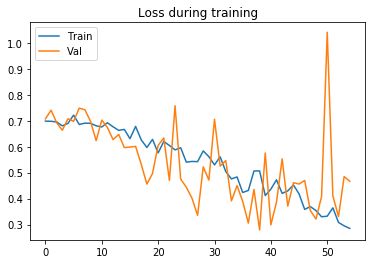

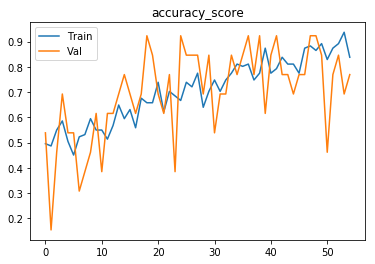

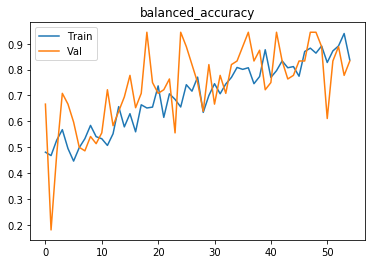

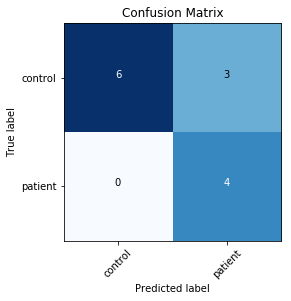

Starting trial 8
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


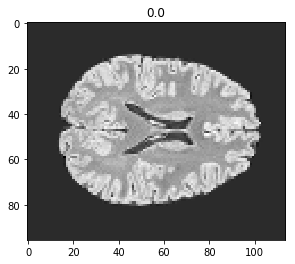

[0,    20] loss: 0.69494
Time elapsed: 0h:0m:3s
train accuracy_score: 48.65 %
train balanced_accuracy: 47.02 %
val accuracy_score: 23.08 %
val balanced_accuracy: 30.56 %
Val loss: 0.729292
[1,    20] loss: 0.70205
Time elapsed: 0h:0m:8s
train accuracy_score: 49.55 %
train balanced_accuracy: 50.72 %
val accuracy_score: 38.46 %
val balanced_accuracy: 55.56 %
Val loss: 0.760103
[2,    20] loss: 0.69248
Time elapsed: 0h:0m:13s
train accuracy_score: 49.55 %
train balanced_accuracy: 46.61 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.721167
[3,    20] loss: 0.68736
Time elapsed: 0h:0m:17s
train accuracy_score: 54.95 %
train balanced_accuracy: 53.98 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.742998
[4,    20] loss: 0.70242
Time elapsed: 0h:0m:22s
train accuracy_score: 48.65 %
train balanced_accuracy: 46.45 %
val accuracy_score: 53.85 %
val balanced_accuracy: 45.83 %
Val loss: 0.685172
[5,    20] loss: 0.69181
Time elapsed: 0h:0m:27s
tra

[43,    20] loss: 0.46492
Time elapsed: 0h:3m:21s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.56 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.574676
[44,    20] loss: 0.47989
Time elapsed: 0h:3m:26s
train accuracy_score: 80.18 %
train balanced_accuracy: 79.99 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.83 %
Val loss: 0.479367
[45,    20] loss: 0.47359
Time elapsed: 0h:3m:31s
train accuracy_score: 78.38 %
train balanced_accuracy: 77.95 %
val accuracy_score: 84.62 %
val balanced_accuracy: 81.94 %
Val loss: 0.415386
[46,    20] loss: 0.48677
Time elapsed: 0h:3m:35s
train accuracy_score: 79.28 %
train balanced_accuracy: 79.03 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.436352
[47,    20] loss: 0.42983
Time elapsed: 0h:3m:40s
train accuracy_score: 79.28 %
train balanced_accuracy: 79.14 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.611464
[48,    20] loss: 0.42635
Time elapsed: 0h:3m

[86,    20] loss: 0.07627
Time elapsed: 0h:6m:39s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.129428
[87,    20] loss: 0.06793
Time elapsed: 0h:6m:44s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.439888
[88,    20] loss: 0.06917
Time elapsed: 0h:6m:49s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.283718
[89,    20] loss: 0.04813
Time elapsed: 0h:6m:53s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.333022
[90,    20] loss: 0.04788
Time elapsed: 0h:6m:58s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.365750
[91,    20] loss: 0.04413
Time elapsed:

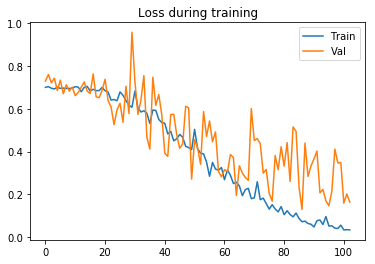

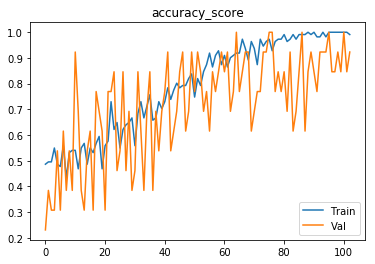

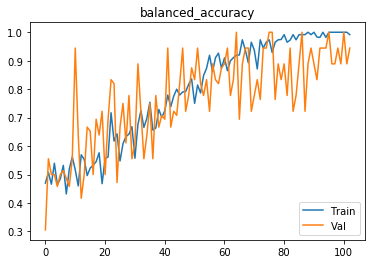

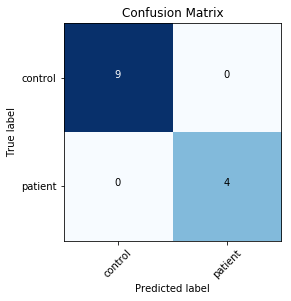

Starting trial 9
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


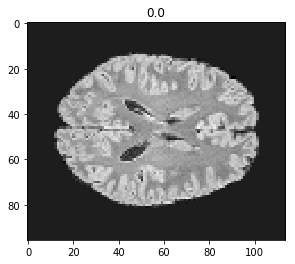

[0,    20] loss: 0.70889
Time elapsed: 0h:0m:4s
train accuracy_score: 50.45 %
train balanced_accuracy: 48.94 %
val accuracy_score: 46.15 %
val balanced_accuracy: 33.33 %
Val loss: 0.685198
[1,    20] loss: 0.69978
Time elapsed: 0h:0m:8s
train accuracy_score: 49.55 %
train balanced_accuracy: 47.98 %
val accuracy_score: 53.85 %
val balanced_accuracy: 66.67 %
Val loss: 0.691052
[2,    20] loss: 0.70021
Time elapsed: 0h:0m:13s
train accuracy_score: 48.65 %
train balanced_accuracy: 49.19 %
val accuracy_score: 23.08 %
val balanced_accuracy: 37.50 %
Val loss: 0.699287
[3,    20] loss: 0.70361
Time elapsed: 0h:0m:17s
train accuracy_score: 48.65 %
train balanced_accuracy: 46.33 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.695807
[4,    20] loss: 0.69637
Time elapsed: 0h:0m:22s
train accuracy_score: 52.25 %
train balanced_accuracy: 49.38 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.715526
[5,    20] loss: 0.68682
Time elapsed: 0h:0m:26s
tra

[43,    20] loss: 0.50258
Time elapsed: 0h:3m:21s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.48 %
val accuracy_score: 53.85 %
val balanced_accuracy: 59.72 %
Val loss: 0.549733
[44,    20] loss: 0.54230
Time elapsed: 0h:3m:26s
train accuracy_score: 72.97 %
train balanced_accuracy: 72.29 %
val accuracy_score: 46.15 %
val balanced_accuracy: 54.17 %
Val loss: 0.694472
[45,    20] loss: 0.55572
Time elapsed: 0h:3m:30s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.71 %
val accuracy_score: 53.85 %
val balanced_accuracy: 66.67 %
Val loss: 0.687211
[46,    20] loss: 0.53297
Time elapsed: 0h:3m:35s
train accuracy_score: 70.27 %
train balanced_accuracy: 69.75 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.392744
[47,    20] loss: 0.50585
Time elapsed: 0h:3m:40s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.56 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.481213
[48,    20] loss: 0.47910
Time elapsed: 0h:3m

[86,    20] loss: 0.11820
Time elapsed: 0h:6m:39s
train accuracy_score: 95.50 %
train balanced_accuracy: 95.65 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.216640
[87,    20] loss: 0.09760
Time elapsed: 0h:6m:44s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.210247
[88,    20] loss: 0.09377
Time elapsed: 0h:6m:48s
train accuracy_score: 95.50 %
train balanced_accuracy: 95.65 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.288318
[89,    20] loss: 0.07440
Time elapsed: 0h:6m:53s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.04 %
val accuracy_score: 92.31 %
val balanced_accuracy: 87.50 %
Val loss: 0.210420
[90,    20] loss: 0.08301
Time elapsed: 0h:6m:57s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.04 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.265737
[91,    20] loss: 0.07535
Time elapsed: 0h:

val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.269028
[129,    20] loss: 0.01047
Time elapsed: 0h:9m:56s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.148459
[130,    20] loss: 0.01977
Time elapsed: 0h:10m:0s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.132119
[131,    20] loss: 0.01208
Time elapsed: 0h:10m:5s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.145670
[132,    20] loss: 0.01171
Time elapsed: 0h:10m:10s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.561758
[133,    20] loss: 0.01640
Time elapsed: 0h:10m:14s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 100.00 %

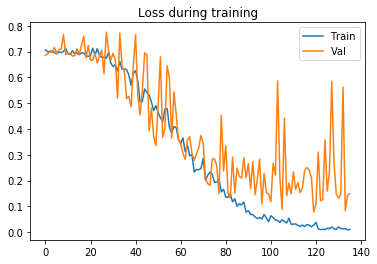

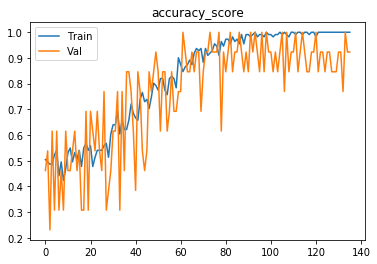

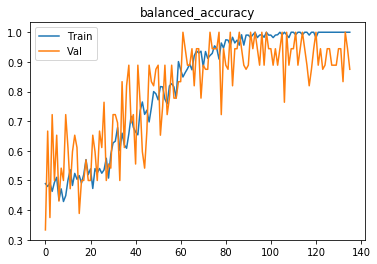

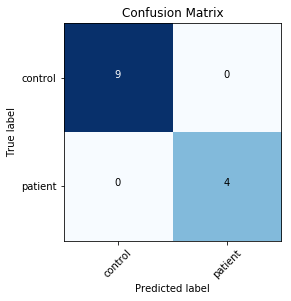

################################
################################
All accuracies: [0.8888888888888888, 0.8333333333333333, 1.0, 0.6944444444444444, 0.7777777777777778, 0.7777777777777778, 0.8888888888888888, 0.8333333333333333, 0.9444444444444444, 0.875]
Best accuracies mean: 0.9722222222222221 All :[1.0, 0.9444444444444444, 1.0, 0.8888888888888888, 1.0, 0.9444444444444444, 1.0, 0.9444444444444444, 1.0, 1.0]
0.851388888888889
0.08380652689747549


In [23]:
fold_metric, models = run(net=net, data=ms_data_train,
                  k_folds=-1,
                  callbacks=callbacks,
                  augmentations=augmentations,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [24]:
5/0

ZeroDivisionError: division by zero

# Start inference

### Using best model checkpoint for inference

In [46]:
test_loader = DataLoader(
            ms_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [47]:
model_dirs = [os.path.join(output_dir,"repeat_{}_cv_fold_{}_BEST_ITERATION.h5".format(r, i)) for i in range(10)]

In [49]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    net = SixtyFourNet()
    net.load_state_dict(torch.load(model_dir))
    net = net.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} %".format(np.mean(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} %".format(np.mean(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} %".format(np.mean(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} %".format(np.mean(metrics_df["Specificity"])*100))

Fold 0
Bal. accuracy 80.000 %
ROC AUC Score 93.846 %
Sensitivity 100.000 %
Specificity 60.000 %
Fold 1
Bal. accuracy 74.615 %
ROC AUC Score 82.308 %
Sensitivity 69.231 %
Specificity 80.000 %
Fold 2
Bal. accuracy 71.154 %
ROC AUC Score 86.923 %
Sensitivity 92.308 %
Specificity 50.000 %
Fold 3
Bal. accuracy 77.308 %
ROC AUC Score 84.615 %
Sensitivity 84.615 %
Specificity 70.000 %
Fold 4
Bal. accuracy 72.308 %
ROC AUC Score 85.385 %
Sensitivity 84.615 %
Specificity 60.000 %
Fold 5
Bal. accuracy 71.154 %
ROC AUC Score 89.231 %
Sensitivity 92.308 %
Specificity 50.000 %
Fold 6
Bal. accuracy 80.000 %
ROC AUC Score 93.077 %
Sensitivity 100.000 %
Specificity 60.000 %
Fold 7
Bal. accuracy 72.308 %
ROC AUC Score 86.154 %
Sensitivity 84.615 %
Specificity 60.000 %
Fold 8
Bal. accuracy 76.154 %
ROC AUC Score 89.231 %
Sensitivity 92.308 %
Specificity 60.000 %
Fold 9
Bal. accuracy 85.000 %
ROC AUC Score 96.923 %
Sensitivity 100.000 %
Specificity 70.000 %
######## Final results ########
    Bal Acc   R

In [29]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    net = SixtyFourNet()
    net.load_state_dict(torch.load(model_dir))
    net = net.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))

Fold 0
0.85
Fold 1
0.6846153846153846
Fold 2
0.823076923076923
Fold 3
0.6846153846153846
Fold 4
0.6461538461538461
Fold 5
0.7115384615384616
Fold 6
0.85
Fold 7
0.7230769230769231
Fold 8
0.8115384615384615
Fold 9
0.85
######## Final results ########
          0
0  0.850000
1  0.684615
2  0.823077
3  0.684615
4  0.646154
5  0.711538
6  0.850000
7  0.723077
8  0.811538
9  0.850000
Balanced accuracy mean 76.35 %
